In [4]:
from functools import partial
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.cluster import GaussianCluster
from graspy.embed import MultipleASE, OmnibusEmbed
from graspy.models import SBMEstimator
from graspy.plot import heatmap
from graspy.simulations import er_np, sbm
from joblib import Parallel, delayed
from scipy.stats import ttest_ind
from sklearn.metrics import adjusted_rand_score

from src import generate_binary_sbms

%matplotlib inline

In [5]:
def estimate_embeddings(X, Y, method):
    """
    Parameters
    ----------
    method : str
        Must be {'mase', 'omni'}
    """
    stacked = np.vstack([X, Y])

    if method == "mase":
        embedder = MultipleASE(2)
        embeddings = embedder.fit_transform(stacked)
    elif method == "omni":
        embedder = OmnibusEmbed(2)
        embeddings = embedder.fit_transform(stacked).mean(axis=0)
    else:
        assert ValueError("Invalid embedding method")

    return embeddings


def estimate_community(embeddings, n_clusters):
    predicted_labels = (
        GaussianCluster(n_clusters, n_clusters, "all").fit_predict(embeddings) + 1
    )

    # ari = adjusted_rand_score(true_labels, predicted_labels)
    return predicted_labels


def compute_ttest(pop1, pop2):
    statistics, pvals = ttest_ind(pop1, pop2, axis=0)

    return pvals

In [6]:
def run_experiment(m, block_1, block_2, p, delta, n_clusters, reps):
    total_n = block_1 + block_2
    r, c = np.triu_indices(total_n, k=1)

    omni_res = np.zeros((reps, len(n_clusters), 2))
    mase_res = np.zeros((reps, len(n_clusters), 2))

    for i in np.arange(reps).astype(int):
        pop1, pop2, true_labels = generate_binary_sbms(
            m=m, block_1=block_1, block_2=block_2, p=p, delta=delta
        )
        pop1_edges = pop1[:, r, c]
        pop2_edges = pop2[:, r, c]
        true_edges = (true_labels[:, None] + true_labels[None, :])[r, c]

        for method in ["mase", "omni"]:
            embeddings = estimate_embeddings(pop1, pop2, method)

            for k_idx, k in enumerate(n_clusters):
                predicted_labels = estimate_community(embeddings, k)
                predicted_edge_labels = (
                    predicted_labels[:, None] * predicted_labels[None, :]
                )[
                    r, c
                ]  # vectorize to uppper triu
                
                communitity_pvals = np.zeros(np.unique(true_edges).size)
                
                cluster_labels = np.unique(predicted_edge_labels)
                for cdx, cluster_label in enumerate(cluster_labels):
                    tmp_labels = predicted_edge_labels == cluster_label
                    statistics, pvals = ttest_ind(
                        pop1_edges[:, tmp_labels].ravel(),
                        pop2_edges[:, tmp_labels].ravel(),
                    )
                    
                    communitity_pvals[cdx] = pvals
                        
                sig_edges = np.zeros((total_n, total_n))[r, c]
                
                #find the most significant group
                sig_comm = cluster_labels[np.argsort(communitity_pvals, kind='stable')[0]]
                sig_edges[predicted_edge_labels == sig_comm] = 1

                prec = (sig_edges[true_edges == 0]).sum() / sig_edges.sum()
                recall = (sig_edges[true_edges == 0]).sum() / (true_edges == 0).sum()

                if method == "mase":
                    mase_res[i, k_idx, :] = (prec, recall)
                else:
                    omni_res[i, k_idx, :] = (prec, recall)

    omni_res = np.nanmean(omni_res, axis=0).reshape(-1)
    mase_res = np.nanmean(mase_res, axis=0).reshape(-1)

    to_append = [m, p, delta, *omni_res, *mase_res]
    return to_append

In [7]:
block_1 = 25  # different probability
block_2 = 25
n_clusters = range(2, 11, 2)
p = 0.5
reps = 50
spacing = 50
deltas = np.linspace(0, 1 - p, spacing + 1)
ms = np.linspace(0, 250, spacing + 1)[1:]

In [4]:
partial_func = partial(
    run_experiment,
    block_1=block_1,
    block_2=block_2,
    p=p,
    n_clusters=n_clusters,
    reps=reps,
)
args = [dict(m=m, delta=delta) for m, delta in product(ms, deltas)][::2]

args = sum(zip(reversed(args), args), ())[: len(args)]

In [ ]:
res = Parallel(n_jobs=-1, verbose=7)(delayed(partial_func)(**arg) for arg in args)

cols = [
    "m",
    "p",
    "delta",
    *[f"omni_{metric}_{k}" for k in n_clusters for metric in ["precision", "recall"]],
    *[f"mase_{metric}_{k}" for k in n_clusters for metric in ["precision", "recall"]],
]
res_df = pd.DataFrame(res, columns=cols)

res_df.to_csv(f"./results/20200222_correct_nodes_1.csv", index=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed: 129.4min


## Figures

In [3]:
res_df = pd.read_csv("../results/20200222_correct_nodes.csv")
res_df.fillna(0, inplace=True)
res_df.head()

,Unnamed: 0,m,p,delta,omni_precision_2,omni_recall_2,omni_precision_3,omni_recall_3,omni_precision_4,omni_recall_4,...,omni_precision_8,omni_recall_8,omni_precision_10,omni_recall_10,mase_precision_6,mase_recall_6,mase_precision_8,mase_recall_8,mase_precision_10,mase_recall_10
0,1,5.0,0.5,0.00,0.236447,0.052867,0.210475,0.037000,0.223546,0.039600,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
1,1276,5.0,0.5,0.01,0.250396,0.055667,0.000000,0.000000,0.232932,0.039533,...,0.262536,0.057533,0.250150,0.041800,0.241828,0.062400,0.285204,0.0646,0.267823,0.053733
2,3,5.0,0.5,0.02,0.223236,0.079867,0.280044,0.089600,0.262696,0.054667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
3,1278,5.0,0.5,0.03,0.276759,0.131467,0.000000,0.000000,0.261054,0.094933,...,0.296676,0.056000,0.293895,0.051467,0.268167,0.081933,0.220112,0.0564,0.217594,0.063867
4,5,5.0,0.5,0.04,0.268118,0.140267,0.239296,0.091467,0.317777,0.096533,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000


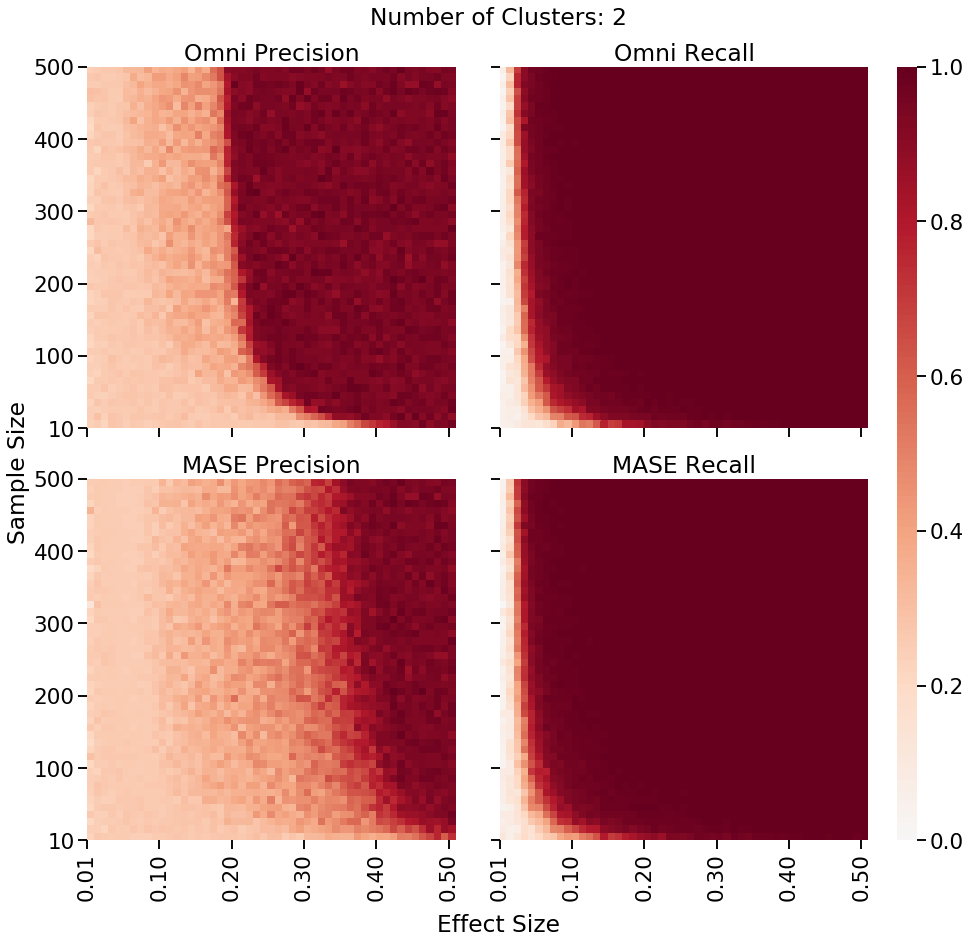

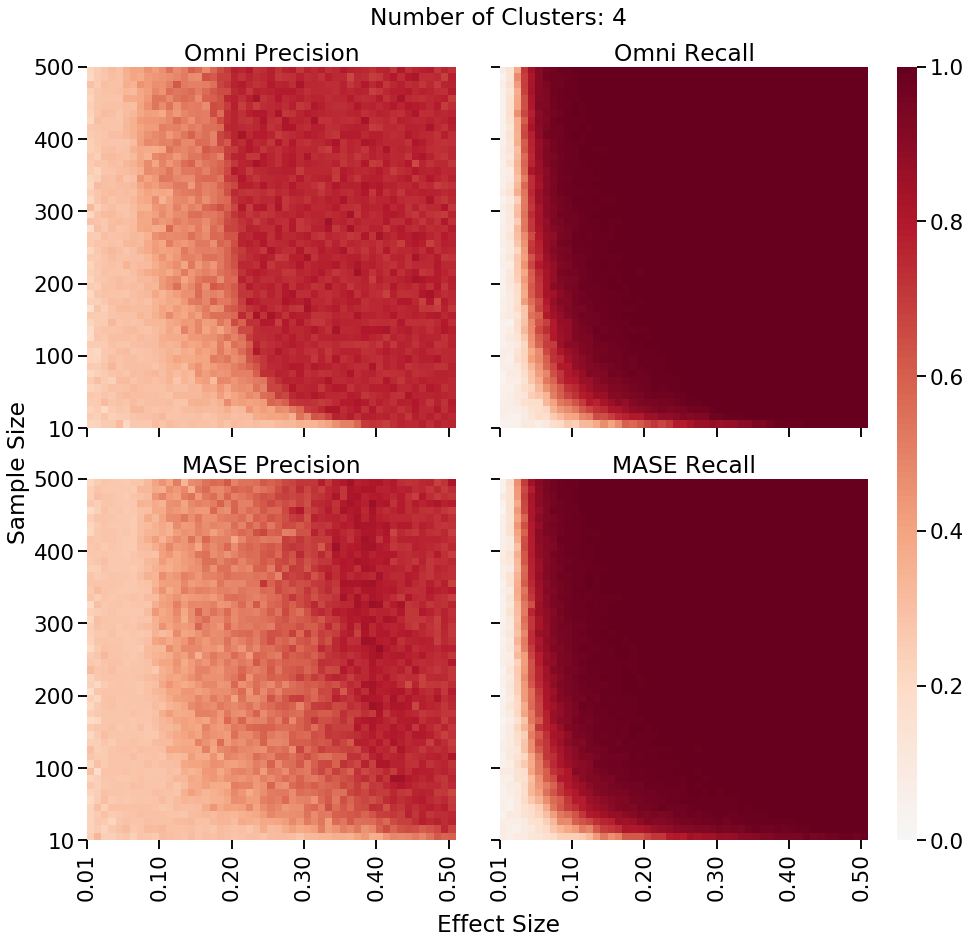

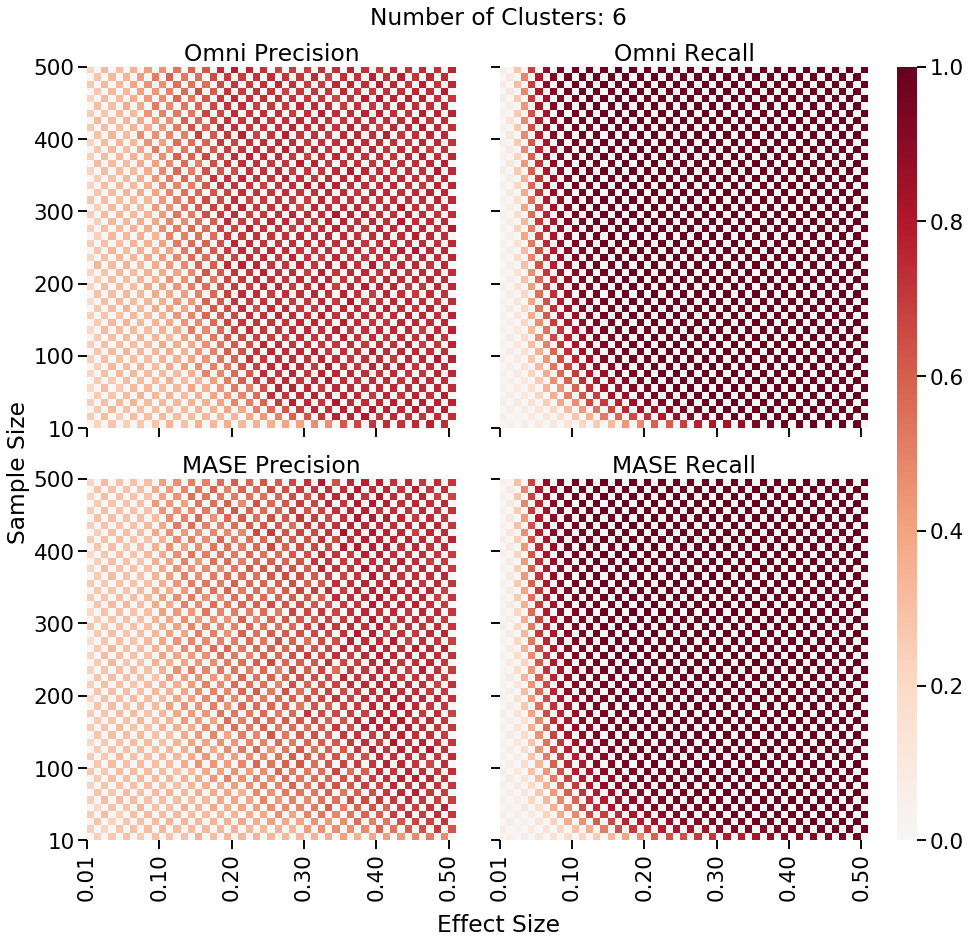

In [4]:
rows = ["omni", "mase"]
cols = ["_precision_", "_recall_"]

xticklabels = np.linspace(0, 1 - p, spacing + 1)[::10]
xticklabels[0] += 0.01
yticklabels = np.linspace(0, 250, spacing + 1)[::10] * 2
yticklabels[0] += 10


for k in range(2, 7, 2):
    # Make figure with correct subplots
    sns.set_context("talk", font_scale=1.3)
    fig, ax = plt.subplots(
        2,
        3,
        gridspec_kw={"width_ratios": [1, 1, 0.05]},
        figsize=(13, 12),
        sharex=True,
        sharey=True,
        constrained_layout=True,
    )
    gs = ax[-1, -1].get_gridspec()
    for ax_ in ax[:, -1]:
        ax_.remove()
    ax_leg = fig.add_subplot(gs[:, -1])

    for i, method in enumerate(rows):
        for j, metric in enumerate(cols):
            sns.heatmap(
                np.flipud(res_df[f"{method}{metric}{k}"].values.reshape(spacing, -1)),
                ax=ax[i, j],
                square=True,
                center=0,
                cmap="RdBu_r",
                cbar_kws=dict(shrink=0.7),
                xticklabels=["{:.2f}".format(x) for x in xticklabels],
                yticklabels=["{:.0f}".format(y) for y in yticklabels],
                cbar_ax=ax_leg,
                vmin=0,
                vmax=1,
            )
            ax[i, j].set_xticks(np.arange(0, ax[0, 0].get_xlim()[1] + 1, 10))
            ax[i, j].set_yticks(np.arange(0, ax[0, 0].get_ylim()[0] + 1, 10)[::-1])

            if i == 0:
                row_name = "Omni"
            else:
                row_name = "MASE"
            if j == 0:
                col_name = "Precision"
            elif j == 1:
                col_name = "Recall"
            ax[i, j].set_title(f"{row_name} {col_name}")

    fig.text(0.5, 1.025, f"Number of Clusters: {k}", va="center", ha="center")
    fig.text(-0.025, 0.5, "Sample Size", va="center", rotation="vertical")
    fig.text(0.5, -0.025, "Effect Size", va="center", ha="center")
    
    fig.savefig(
        f"./exp3_estimated_community_k={k}.png", dpi=300, bbox_inches="tight"
    )
    fig.savefig(
        f"./exp3_estimated_community_k={k}.pdf", dpi=300, bbox_inches="tight"
    )